In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d

import read_qdp
import os
import sys

In [14]:
class IV_curve(object):
    '''
    
    Methods:
    self.plotPV() - plots PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    self.plotRegions(raw=1) - set raw to false to plot analysed IV regions
    
    #TODO - Store the temperatures in the object
    '''
    
    def __init__(self, rawIV, params = 0, name='NA'): 
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two coloums of the dataframe and saves 
        them as attributes. Dataframe can consist of more coloums but they are ignored. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be inlcuded as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attriutes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - whether the data shows signs of superconductivity
        y_offset (float) 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- experimental parameters
        gain (float) - calcuated from M_ratio and R_fb
        R_stray (float) - either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        # Drop NaNs in spreadsheet to prevent errors later 
        self.rawI = (rawIV.iloc[:,0].dropna()).values #Store as individual np.arrays for more readable code
        self.rawV = (rawIV.iloc[:,1].dropna()).values
        # Search for columns with T in the header then refine into BB or bath
        self.T_BB = rawIV.iloc[:,4].dropna().values
        self.T_bath = rawIV.iloc[:,3].dropna().values
        
        self.raw_grad = np.gradient(self.rawV, self.rawI)#Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend
        
        #iniditalise these values with the methods
        self.name = name
        self.y_offset = 0
        
        # All needed to calculate adjusted I and V etc. If params are included in initialisation, then they are
        # used. Otherwise defualts are used.
        # TODO: raise exception if len is not 3
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except IndexError:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using defualt paramters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        
    ############################calc_methods############################   
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float), gain (float).
        tweaks not yet used
        '''
        
        self.I_TES = [(entry - self.y_offset) * (10**6) * self.gain for entry in self.rawV]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates V_bias data
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Test if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if max(grad) > 3*(grad_av) and abs(min(grad)) > 5*(grad_av):
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    ############################utility methods############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def fit_ohmic(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        r1start, r1end = (0,7)
        r2start, r2end = (-7,-1)
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:r2end]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:r2end]
        lineDataX = np.append(xvals1, xvals2)

        #fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def power_readout(self, plot = 0):
        indices = []
        count = 0 
        for index in range(len(self.raw_grad)):
            if self.raw_grad[index] < 0:
                count += 1
            else:
                count = 0
            if count >= 3:
                indices.append(index-count)
                break
                    
        count = 0
        for index in range(len(self.raw_grad)):
            if self.raw_grad[-index] < 0:
                count += 1
            else:
                count = 0
            if count >= 3:
                indices.append(-(index-count))
                break
        readout = 0  
        if plot:
            if len(indices) == 2:
                readout = (self.P_TES[indices[0]] +  self.P_TES[indices[1]])/2
            elif len(indices) == 1:
                readout = self.P_TES[indices[0]]
            else:
                readout = 0
        
        self.readout_idx = indices
        
        return readout
    
    ###############Plotting Methods###################
    def plotRaw(self):
        plt.scatter(self.rawI, self.rawV, label='Raw IV')
        plt.grid()
        plt.xlabel('Current Bias (mA)')
        plt.ylabel('Feedback Voltage (V)')
        plt.title('Raw IV')
        plt.show()
        
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV')
            if len(self.readout_idx) == 2:
                plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            
    def plotPR(self, name = ''):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')#, alpha=0.2)
        plt.title("Power vs Resistance Curve: Index - " + str(name))
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.axvline(self.rnn, color='r',label='Rnn: ' + str(round(self.rnn,5)))
        plt.legend()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        
        
        
    ###############Methods TODO###################
    def smooth_IV(): #Remove qunatum jumps?
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass
    
    def reject_outliers(self, data, m = 2.):
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def y_search(self, step, pivot, precision):

        ys = []
        counts = []
        
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        
        for y_off in np.arange(pivot-(10*step),pivot+(step*10),step/10):
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[index] * V_bias[index] for index in range(len(self.I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            count =0
            max_R = max(R_TES)
            
            #for entry in P_grad_smooth:
                #count += abs(entry)**2
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10* entry **2
            
            for entry in R_TES:
                if entry < 0:
                    count += 10* entry**2
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]
        

        return self.y_search(step/10, y_offset, precision)
        
    def reverse_y_offset(self):
        '''Requires R_stray to have been already calculated or input.
        Attempts to calc offset through optimising the power plot. 
        '''
        self.y_search(5,0,0.000001)
        
    def calc_all(self):
        self.power_readout()
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.reverse_y_offset()
        
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.calc_P_TES()
        self.calc_R_TES()

In [4]:
class IV_series(object):
    
    def __init__(self, dirname, params):
        self.R_nn = 0
        self.R_stray = 0 
        self.read_data(dirname)
        self.data = [IV_curve(series, params) for series in self.series]
        
        print(self.data)
    
    def set_R_stray(self, val):
        self.R_stray = val
        
    def set_rnn(self, val):
        self.R_nn = val
        
    def calc_R_stray(self):
        pass # TODO impliment 
        
        
    def calc_R_nn(self):
        average = 0
        for IV_curve in self.data:
            IV_curve.plotIV(False)
            average += IV_curve.rnn
        
        IV_series.R_nn = average/len(self.data)
    
    
    def read_data(self, dirname):
        series = []
        for filename in os.listdir(dirname):
            if filename.endswith(".qdp"):
                print(filename)
                series.append(read_qdp.read_qdp(dirname+ '\\' +filename))
        self.series = series    
        
    def plot_power(self):
        powers = []
        t_bath = []
        for entry in self.data:
            if entry.superconducting:
                powers.append(entry.power_readout(True))
                t_bath.append(np.average(entry.T_bath))
            
        self.t_bath = t_bath
        self.powers = powers
        plt.scatter(t_bath, powers)
        plt.axis([0,100,0,0.01])
        plt.grid()
        plt.show
        
    def f2(x, K, T_c, n):
        return K*(T_c**n - x**n)
    
    def fit_power(self):

        xdata = [entry/1000 for entry in self.t_bath]
        ydata = [entry *1000 for entry in self.powers]

        plt.scatter(xdata, ydata)
        popt, pcov = curve_fit(f2, xdata, ydata)
        nxdata = np.arange(0, max(xdata)*1.2, 0.0001)
        plt.plot(nxdata, f2(nxdata, *popt), 'r-')
        plt.grid()
        
        return popt

In [15]:
s = IV_series('test', [100002.9, 3.18541, 0.004567])

IVTES2gain10_28.75mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_29.88mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_40.53mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_50.58mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_60.30mK_BB3.16K_magnet0uA.qdp
IVTES2gain10_65.19mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_69.97mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_74.76mK_BB3.17K_magnet0uA.qdp
IVTES2gain10_79.53mK_BB3.17K_magnet0uA.qdp
[<__main__.IV_curve object at 0x0000022A82D326A0>, <__main__.IV_curve object at 0x0000022A82D327B8>, <__main__.IV_curve object at 0x0000022A82D32EF0>, <__main__.IV_curve object at 0x0000022A8462AFD0>, <__main__.IV_curve object at 0x0000022A8462A668>, <__main__.IV_curve object at 0x0000022A8462AF60>, <__main__.IV_curve object at 0x0000022A8462A2B0>, <__main__.IV_curve object at 0x0000022A8355CB00>, <__main__.IV_curve object at 0x0000022A8355CEB8>]


In [16]:
for entry in s.data:
    #for i in range(10):
        #entry.R_stray = i/1000
    entry.R_stray = 0.00239
    entry.calc_all()

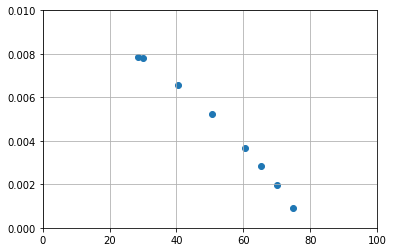

In [37]:
s.plot_power()

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


array([1.03209056e+03, 7.92103109e-02, 1.85788707e+00])

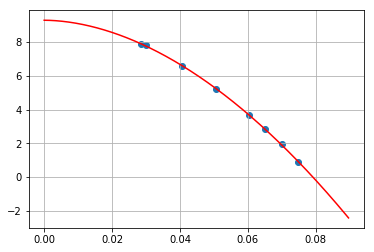

In [40]:
s.fit_power()

In [41]:
def f2(x, K, T_c, n):
    return K*(T_c**n - x**n)

xdata = [entry/1000 for entry in s.t_bb]
ydata = [entry *1000 for entry in s.powers]

plt.scatter(xdata, ydata)
popt, pcov = curve_fit(f2, xdata, ydata)
print(popt)
popt = np.array([1796, 0.078, 2.07])

nxdata = np.arange(0, 0.09, 0.0001)
plt.plot(nxdata, f2(nxdata, *popt), 'r-')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.axis([0.02,0.09,0,9])
print(popt)

AttributeError: 'IV_series' object has no attribute 't_bb'

[1.79755914e+03 7.85043897e-02 2.07472080e+00]
[1.79755914e+03 7.85043897e-02 2.07472080e+00]


C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


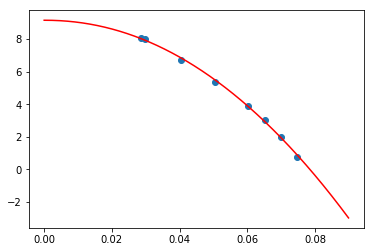

In [23]:
t_bb = [28.55,
29.88,
40.53,
50.58,
60.3,
65.19,
69.97,
74.76
]
power = [8.05587258101616,
7.98903168544144,
6.73185040887773,
5.38962836480807,
3.90571437128607,
3.06106853223913,
1.99649268365377,
0.769885137330173
]

xdata = [entry/1000 for entry in t_bb]
ydata = [entry for entry in power]

plt.scatter(xdata, ydata)
popt, pcov = curve_fit(f2, xdata, ydata)
print(popt)
#popt = np.array([1796, 0.078, 2.07])

nxdata = np.arange(0, 0.09, 0.0001)
plt.plot(nxdata, f2(nxdata, *popt), 'r-')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
#plt.axis([0.02,0.09,0,9])
print(popt)

In [182]:
print(s.powers)
diff = []
for i in range(len(s.powers)-1):
    diff.append(s.powers[i+1] - s.powers[i])

[0.007870873945852659, 0.007822118642656055, 0.006552533957399742, 0.005231159580385676, 0.0036869371110288046, 0.002836194921433533, 0.0019496661890680926, 0.0008973233478293966]


In [186]:
for entry in diff:
    print(entry*1000)

-0.04875530319660426
-1.2695846852563124
-1.321374377014066
-1.5442224693568716
-0.8507421895952716
-0.8865287323654404
-1.0523428412386961


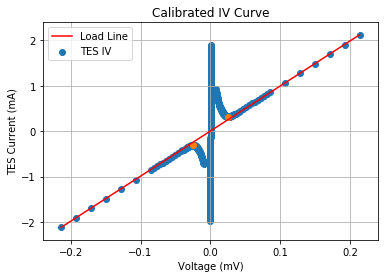

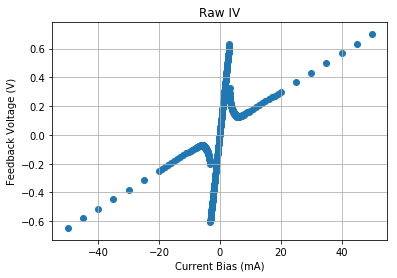

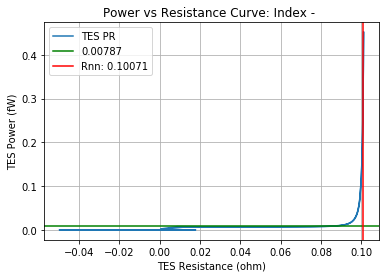

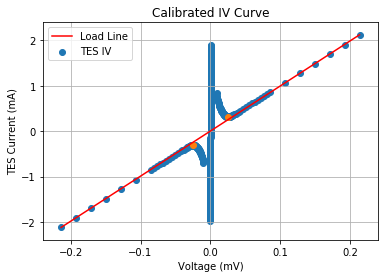

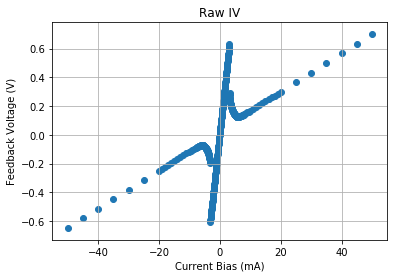

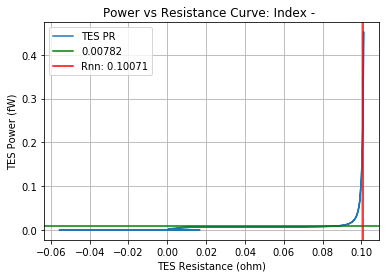

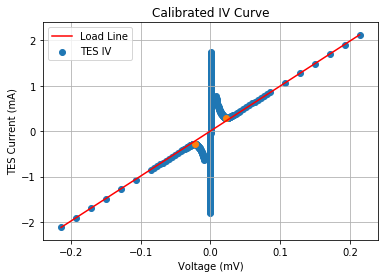

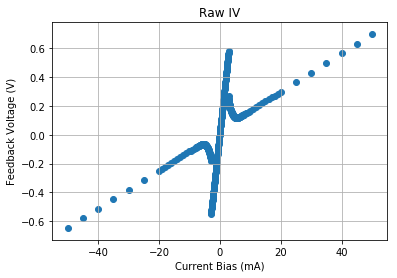

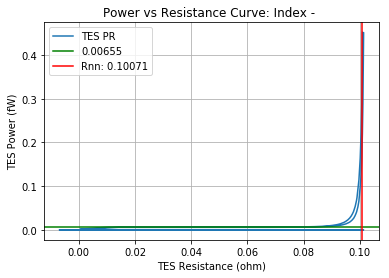

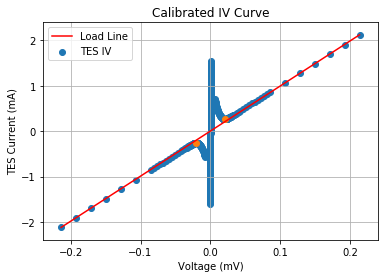

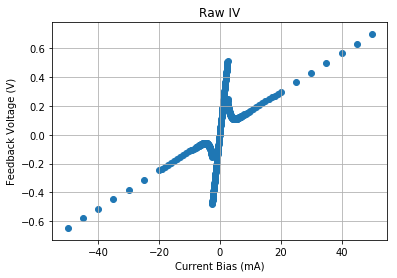

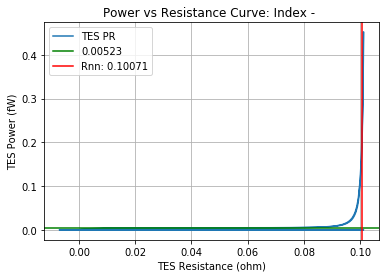

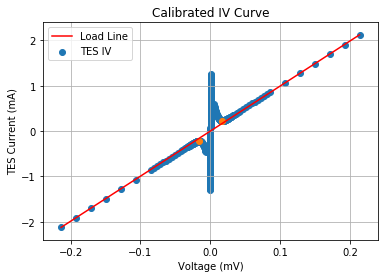

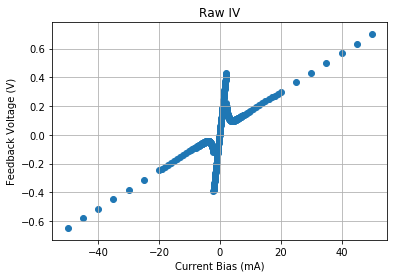

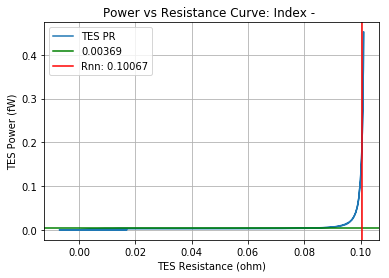

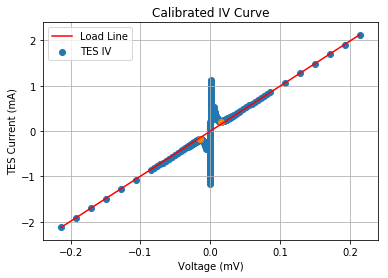

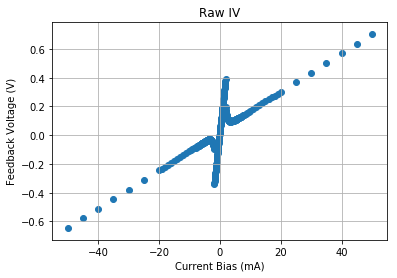

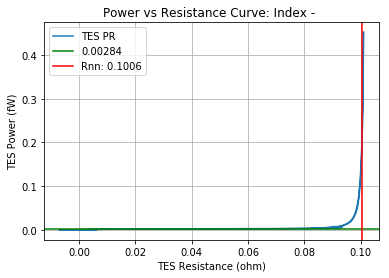

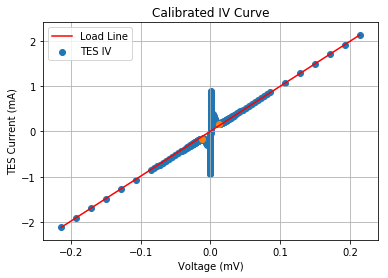

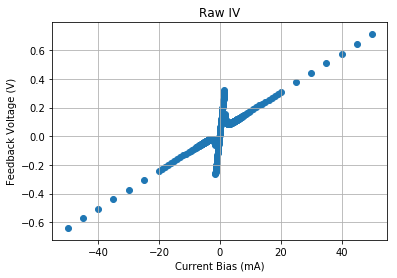

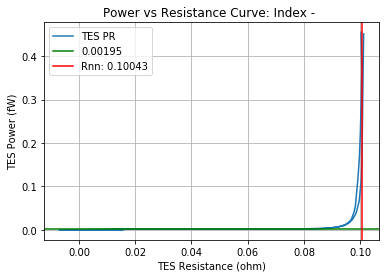

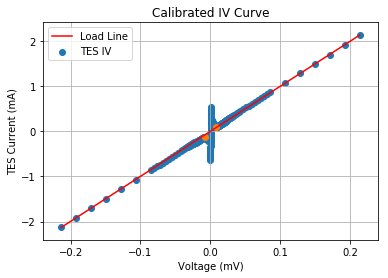

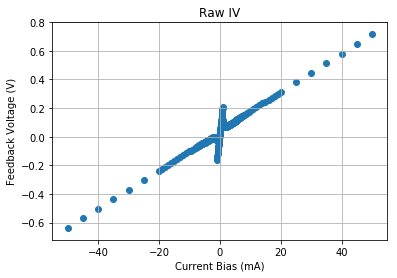

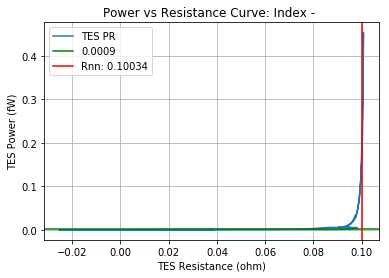

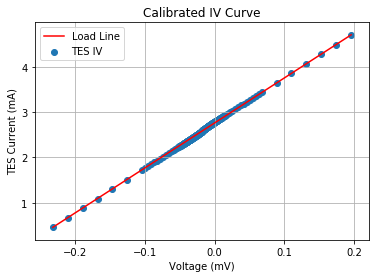

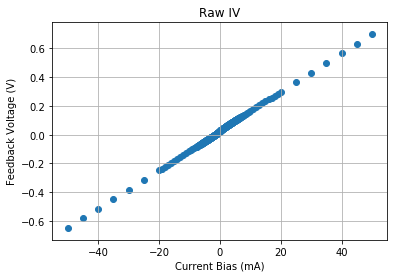

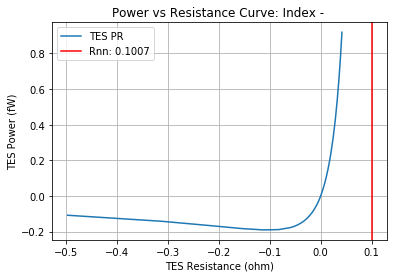

In [17]:
for entry in s.data:
    entry.plotIV()
    plt.show()
    entry.plotRaw()
    entry.plotPR()

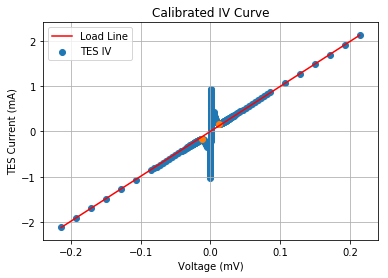

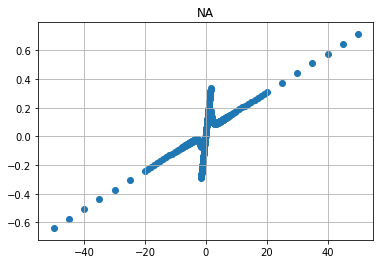

0.034079499999982756


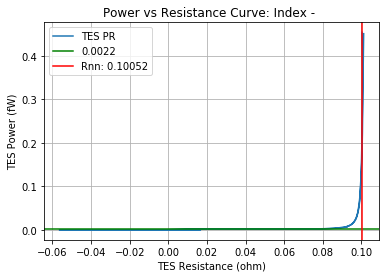

In [149]:
s.data[15].plotIV()
plt.show()
s.data[15].plotRaw()
s.data[15].plotPR()
print(s.data[15].y_offset)

In [71]:
params17D = [30002.9, 18.93333, 0.001278]
dataDict = pd.read_excel(r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\Data\17D_CBB_low.xls', sheet_name=None)
mes_set_17D = [TES(sheet, params17D, name) for name, sheet in dataDict.items()]

NameError: name 'TES' is not defined

In [94]:
paramsT2D = [100002.9, 3.1854103343465, 0.004567]
dataDict = pd.read_excel(r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\Data\TES2dark.xls', sheet_name=None)
mes_set_T2D = [IV_curve(sheet, paramsT2D, name) for name, sheet in dataDict.items()]

C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1003: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1003: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1004: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1005: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1005: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Us

IndexError: list index out of range

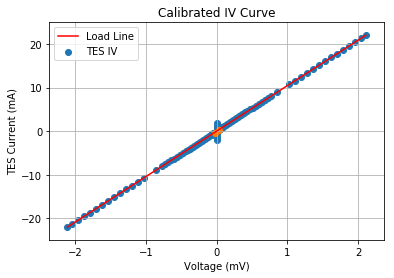

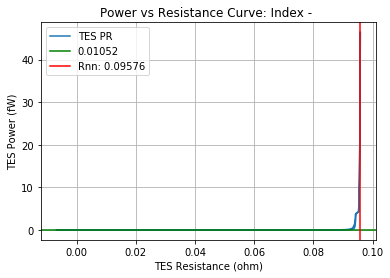

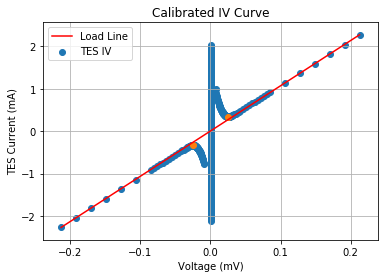

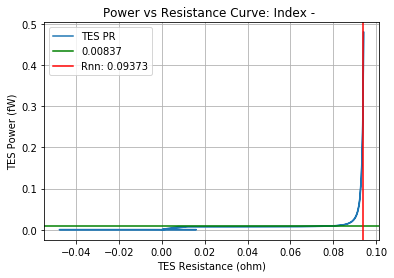

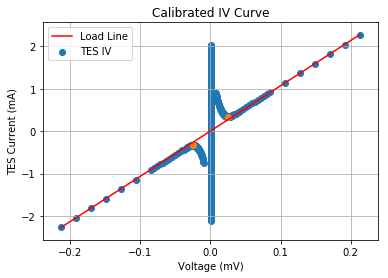

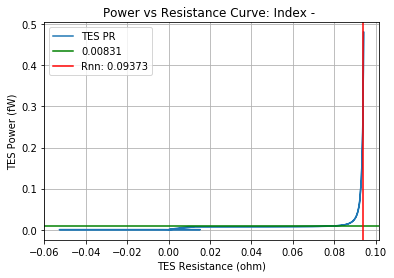

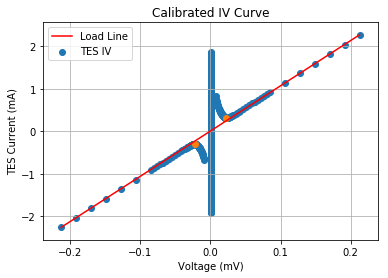

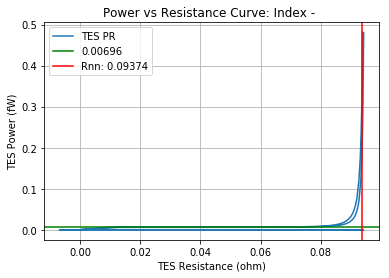

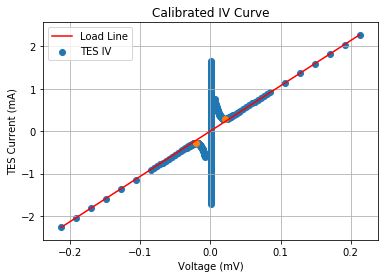

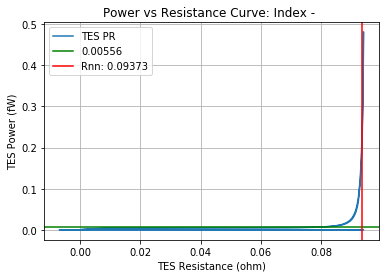

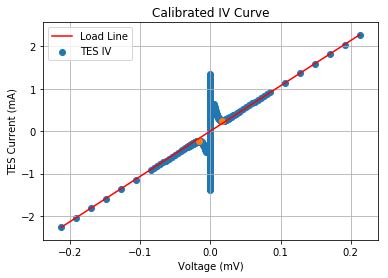

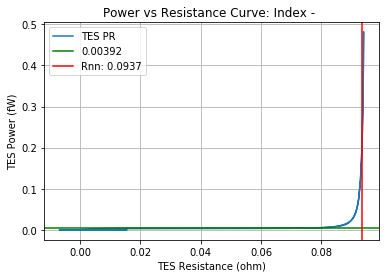

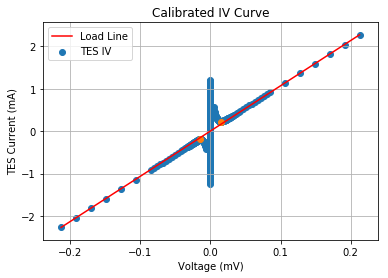

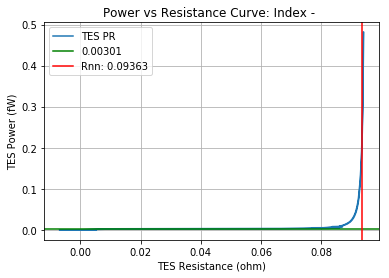

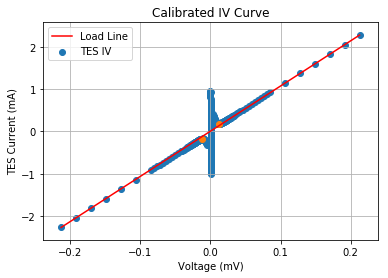

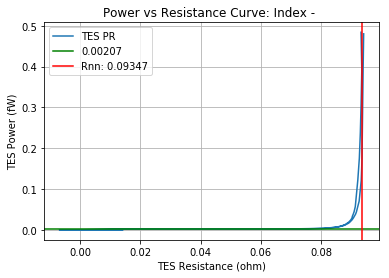

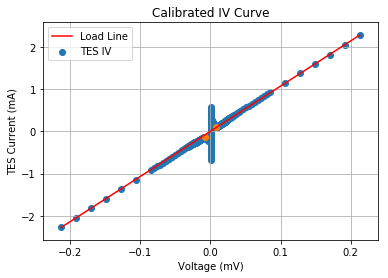

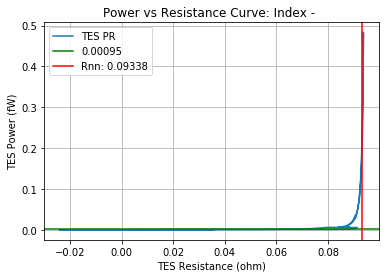

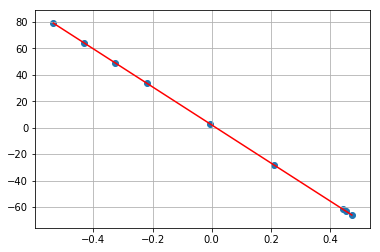

In [95]:
for curve in mes_set_T2D:
    curve.R_stray = 0.00239
    curve.calc_all()
    curve.plotIV()
    curve.plotPR()

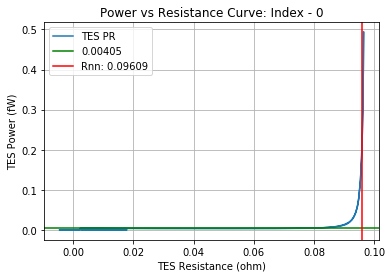

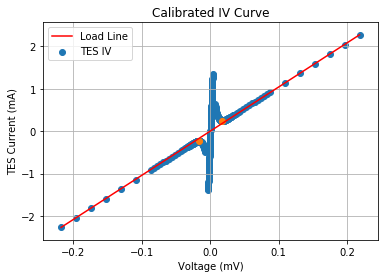

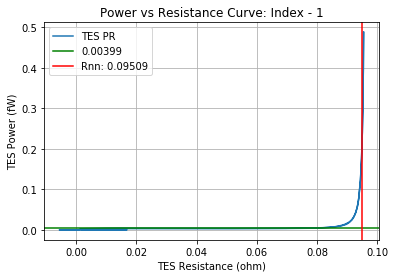

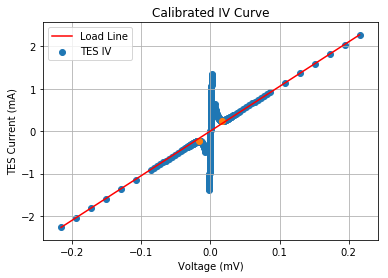

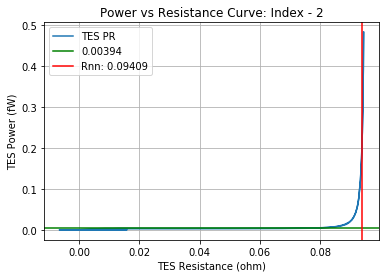

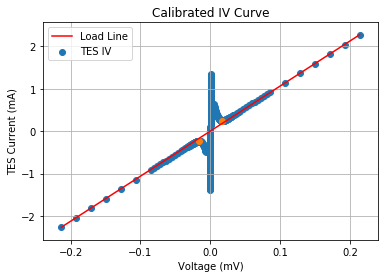

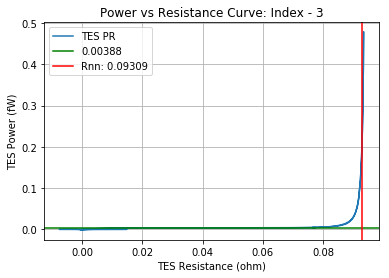

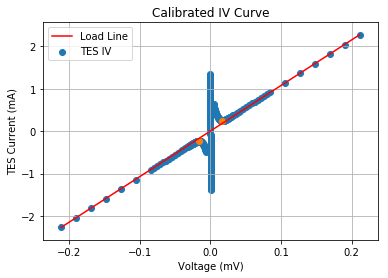

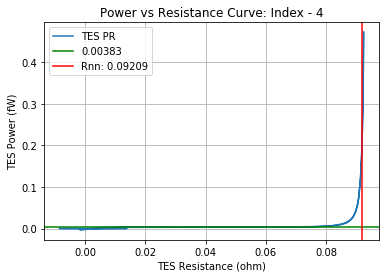

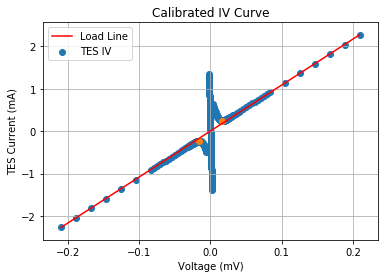

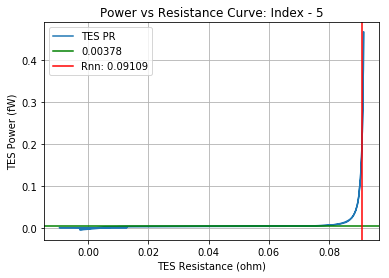

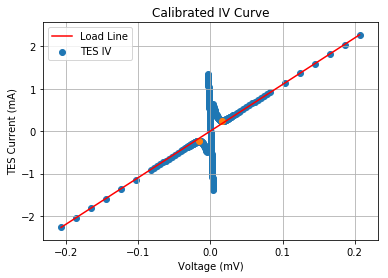

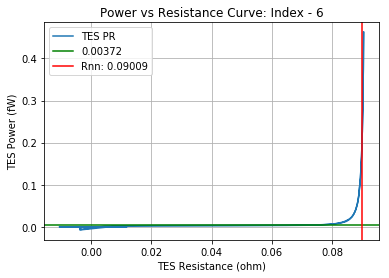

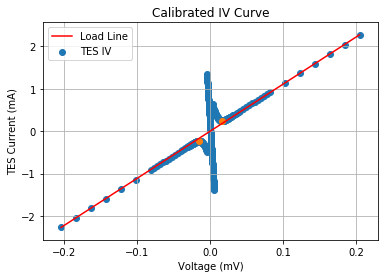

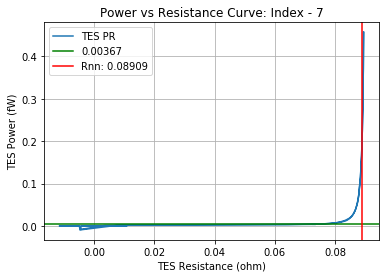

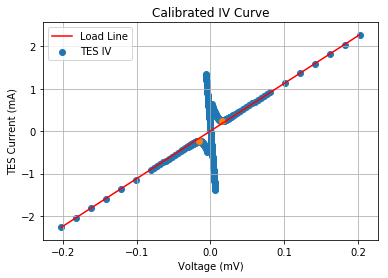

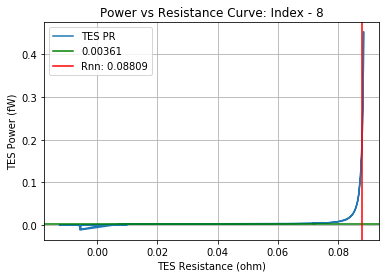

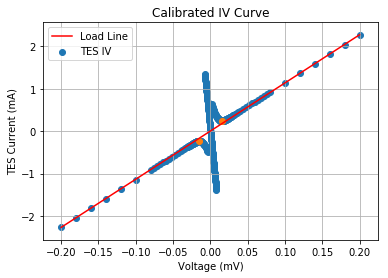

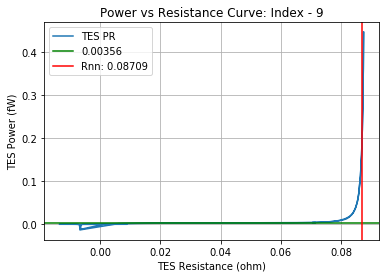

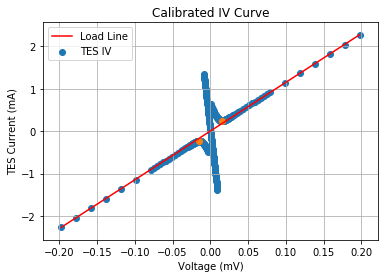

In [103]:
for i in range(10):
    mes_set_T2D[5].R_stray = i/1000
    mes_set_T2D[5].calc_all()
    mes_set_T2D[5].plotPR(i)
    mes_set_T2D[5].plotIV()

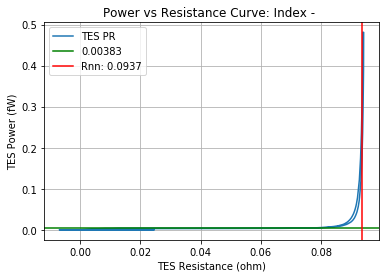

In [47]:
mes_set_T2D[5].calc_I_TES()
mes_set_T2D[5].calc_V_bias()

mes_set_T2D[5].plotIV(False)
mes_set_T2D[5].calc_P_TES()
mes_set_T2D[5].calc_R_TES()

mes_set_T2D[5].plotPR()

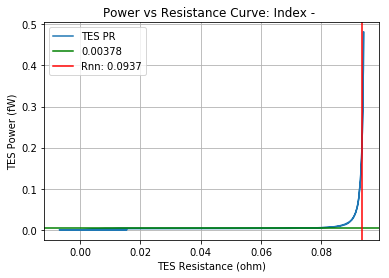

In [48]:
mes_set_T2D[5].calc_all()
mes_set_T2D[5].plotPR()

In [49]:
mes_set_T2D[5].y_offset

0.027722499999983104

In [115]:
def plot_power(self):
        powers = []
        t_bb = []
        for entry in self:
            powers.append(entry.power_readout(True))
            t_bb.append(np.average(entry.T_bath))
            
        plt.scatter(t_bb, powers)
        plt.show

In [121]:
print(mes_set_T2D[0].T_bath)

[-21.99309501 -21.33262312 -20.45332544 -19.56509883 -18.68311576
 -17.79529196 -16.911127   -16.02326963 -15.13900398 -14.25175082
 -13.36624317 -12.47744592 -11.59109909 -10.70230183  -8.92601645
  -8.03846119  -7.59127647  -7.14677714  -6.70395618  -6.3162193
  -5.86735621  -5.41862739  -4.96952933  -4.52080051  -4.29569762
  -4.07079613  -3.84609605  -3.62062392  -3.39474562  -3.17001532
  -2.9458456   -2.72112874  -2.49517659  -2.27005356  -2.04612217
  -1.81998204  -1.59599023  -1.3696252   -1.1457106   -0.92246062
  -0.87732927  -0.83122782  -0.78497532  -0.7424723   -0.69715297
  -0.65205519  -0.60894123  -0.56542448  -0.52128672  -0.47759205
  -0.43362818  -0.39250511  -0.35381366  -0.32860354  -0.36103367
  -0.47991827  -2.02455848  -1.36364349  -0.69834461  -0.03995591
   0.62215608   1.28467223   1.94575169   0.51604958   0.38072266
   0.33781682   0.35998808   0.39826833   0.43964013   0.48169671
   0.52574719   0.57008971   0.61335807   0.65922455   0.70281516
   0.747993

In [117]:
print(mes_set_T2D)

[<__main__.IV_curve object at 0x00000230476C88D0>, <__main__.IV_curve object at 0x000002307AAD2E48>, <__main__.IV_curve object at 0x00000230428CE550>, <__main__.IV_curve object at 0x00000230428CE7F0>, <__main__.IV_curve object at 0x00000230428CED30>, <__main__.IV_curve object at 0x00000230428CE128>, <__main__.IV_curve object at 0x00000230428CE400>, <__main__.IV_curve object at 0x00000230428CE518>, <__main__.IV_curve object at 0x00000230473C68D0>, <__main__.IV_curve object at 0x00000230473C6F98>]


In [118]:
del(mes_set_T2D[-1])

In [119]:
print(mes_set_T2D)

[<__main__.IV_curve object at 0x00000230476C88D0>, <__main__.IV_curve object at 0x000002307AAD2E48>, <__main__.IV_curve object at 0x00000230428CE550>, <__main__.IV_curve object at 0x00000230428CE7F0>, <__main__.IV_curve object at 0x00000230428CED30>, <__main__.IV_curve object at 0x00000230428CE128>, <__main__.IV_curve object at 0x00000230428CE400>, <__main__.IV_curve object at 0x00000230428CE518>, <__main__.IV_curve object at 0x00000230473C68D0>]


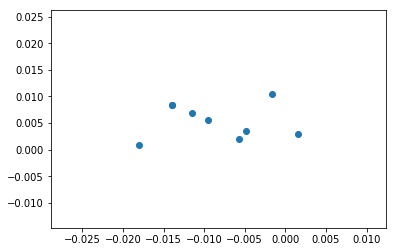

In [120]:
plot_power(mes_set_T2D)